# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data."
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep = ";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ";") 

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('first three columns of azdias data subset:')
azdias.head(3)

first three columns of azdias data subset:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [4]:
print("number of rows/people are: {}".format(azdias.shape[0]))
print("number of columns/features are: {}".format(azdias.shape[1]))

number of rows/people are: 891221
number of columns/features are: 85


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
print("first three columns of azdias features summary:")
feat_info.head(3)

first three columns of azdias features summary:


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"


In [7]:
print("number of rows in azdias features summary data are: {}".format(feat_info.shape[0]))
print("number of columns in azdias features summary data are:{}".format(feat_info.shape[1]))

number of rows in azdias features summary data are: 85
number of columns in azdias features summary data are:4


In [8]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,PLZ8_ANTG3,person,ordinal,[-1]
freq,1,43,49,26


In [9]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values and convert them to NaNs.
#finding number of missing data in azdias data subset
print('Number of missing values in each feature are: {}'.format(azdias.isnull().sum()))

Number of missing values in each feature are: AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                

In [11]:
print('Number of missing values in whole azdias dataframe are: {}'.format(azdias.isnull().sum().sum()))

Number of missing values in whole azdias dataframe are: 4896838


In [12]:
# Identify missing or unknown data values and convert them to NaNs.
for i in range(len(feat_info)):
    Missing_Values = feat_info.iloc[i]['missing_or_unknown']
    Missing_Values = Missing_Values.strip('[')
    Missing_Values = Missing_Values.strip(']')
    Missing_Values = Missing_Values.split(sep=',')
    Missing_Values = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in Missing_Values]
    if Missing_Values != ['']:
        azdias = azdias.replace({feat_info.iloc[i]['attribute']: Missing_Values}, np.nan)
azdias.head()        
    

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [13]:
print("The total number of missing values after converting the digits and -1 to NaN is: {}".format(azdias.isnull().sum().sum()))

The total number of missing values after converting the digits and -1 to NaN is: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
percetage_of_null_values_per_column = (azdias.isnull().sum()/len(azdias))*100
percetage_of_null_values_per_column

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([  0.        ,   9.97576359,  19.95152717,  29.92729076,
         39.90305435,  49.87881794,  59.85458152,  69.83034511,
         79.8061087 ,  89.78187229,  99.75763587]),
 <a list of 10 Patch objects>)

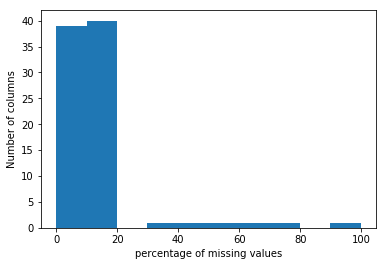

In [15]:
# Investigate patterns in the amount of missing data in each column.
plt.xlabel('percentage of missing values')
plt.ylabel('Number of columns')
plt.hist(percetage_of_null_values_per_column)

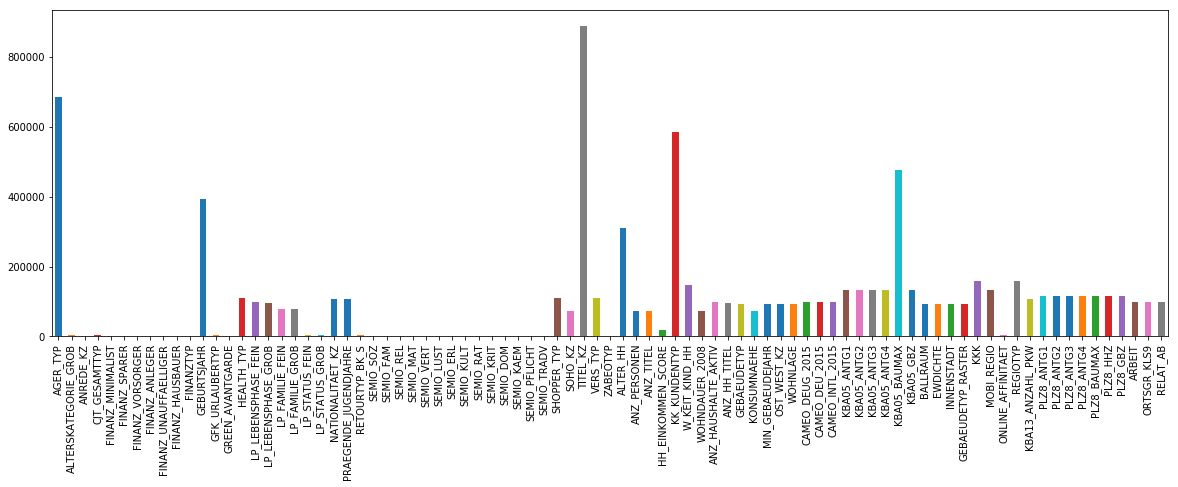

In [16]:
azdias.isnull().sum().sort_values(inplace=True, ascending=False)
azdias.isnull().sum().plot.bar(figsize=(20,6))

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
'''
From the histogram we can note that the outliers are those who have more than 20% of missing data so we can drop them 
'''
percent_missing_per_column_more_than_20 = percetage_of_null_values_per_column[percetage_of_null_values_per_column > 20]
dropped_coloumns = percent_missing_per_column_more_than_20.index.tolist()
print('These columns have more than 20 percent missing data, and will be dropped:{}'.format(dropped_coloumns))

These columns have more than 20 percent missing data, and will be dropped:['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [18]:
azdias = azdias.drop(dropped_coloumns, axis=1)
print('the first 3 columns of azdias data sample after dropping features with more than 20% of missing data:')
azdias.head(3)

the first 3 columns of azdias data sample after dropping features with more than 20% of missing data:


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [19]:
azdias.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,6.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [20]:
print('number of Nan values after excluding the outliers features: {}'.format(azdias.isnull().sum().sum()))

number of Nan values after excluding the outliers features: 5035304


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

After some visualizations it seemed that the outliers are those data with more than 20% of missimg data 

the excluded columns are: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX' and we can note that these data are not that important they are somehow tending to be more personal rather than being that benefitial data that can help us in the future 

about patterns we can note: SEMIO, FINANZ, have no missing values.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

(array([  6.97109000e+05,   7.76340000e+04,   1.28010000e+04,
          9.53300000e+03,   8.29000000e+02,   1.55000000e+02,
          1.40160000e+04,   5.03100000e+03,   2.80380000e+04,
          4.60750000e+04]),
 array([  0.        ,   6.20253165,  12.40506329,  18.60759494,
         24.81012658,  31.01265823,  37.21518987,  43.41772152,
         49.62025316,  55.82278481,  62.02531646]),
 <a list of 10 Patch objects>)

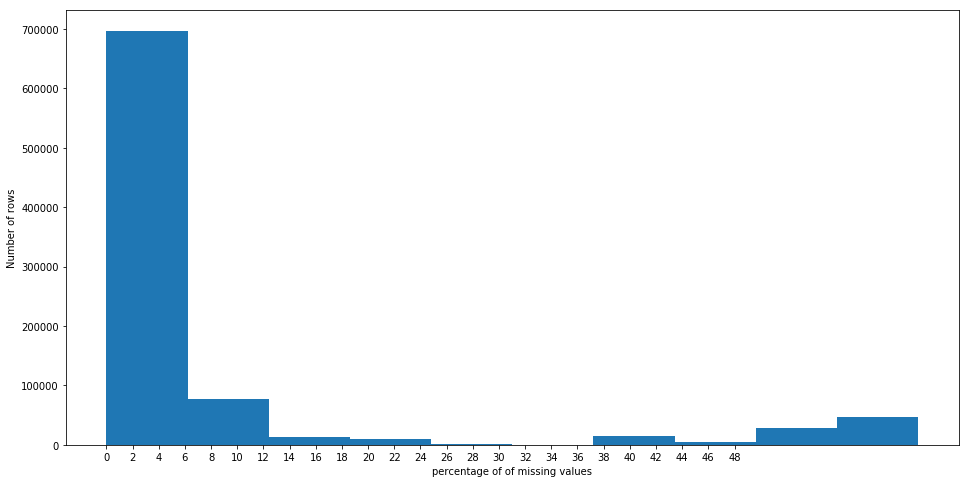

In [21]:
# How much data is missing in each row of the dataset?
percent_null_values_per_row = azdias.isnull().sum(axis=1)/len(azdias.columns)*100
fig=plt.figure(figsize=(16,8))
plt.xticks(np.arange(0,50,2))
plt.xlabel('percentage of of missing values')
plt.ylabel('Number of rows')
plt.hist(percent_null_values_per_row)

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_less_than_or_equal_25 = azdias[percent_null_values_per_row <= 25]
azdias_more_than_25 = azdias[percent_null_values_per_row > 25]


In [23]:
azdias_less_than_or_equal_25.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0


In [24]:
azdias_more_than_25.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


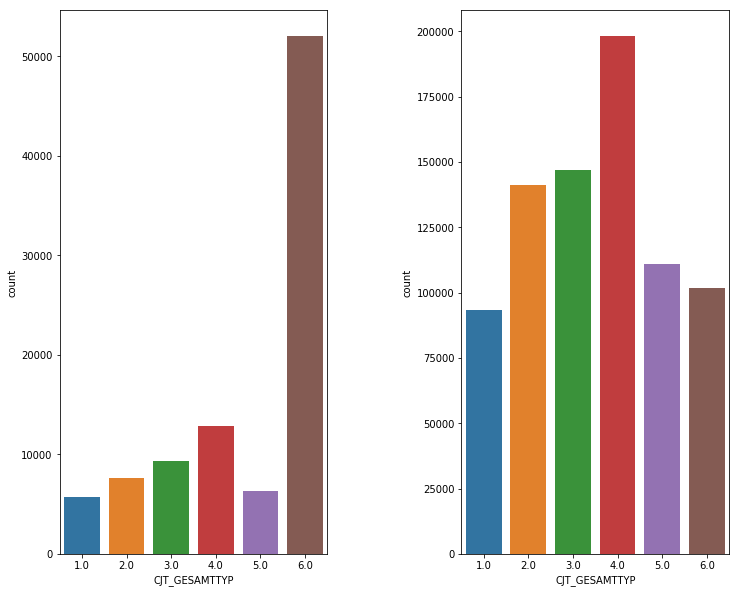

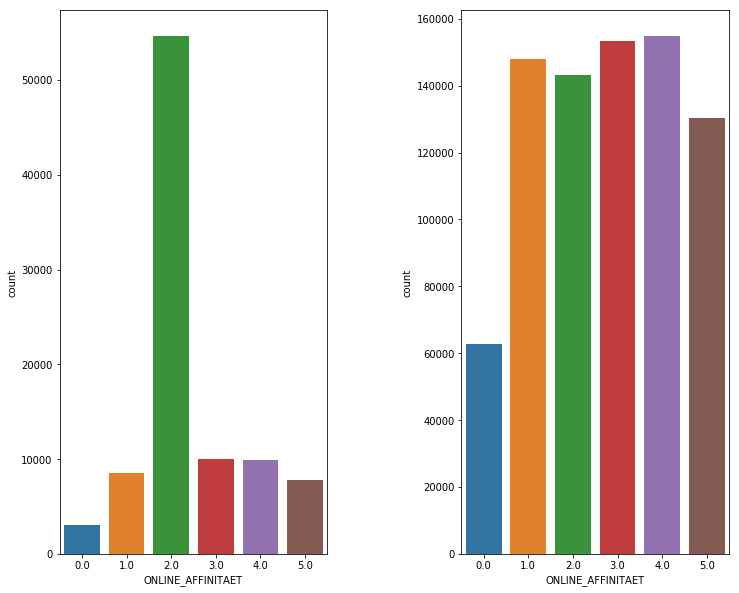

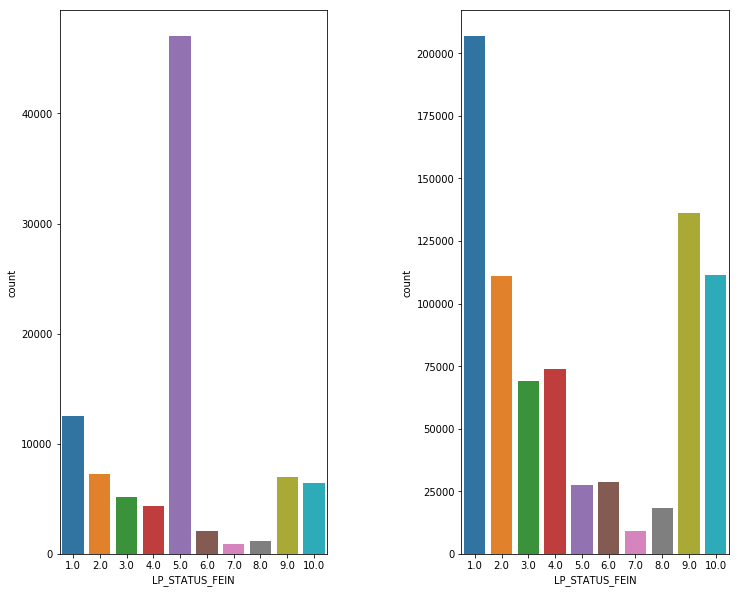

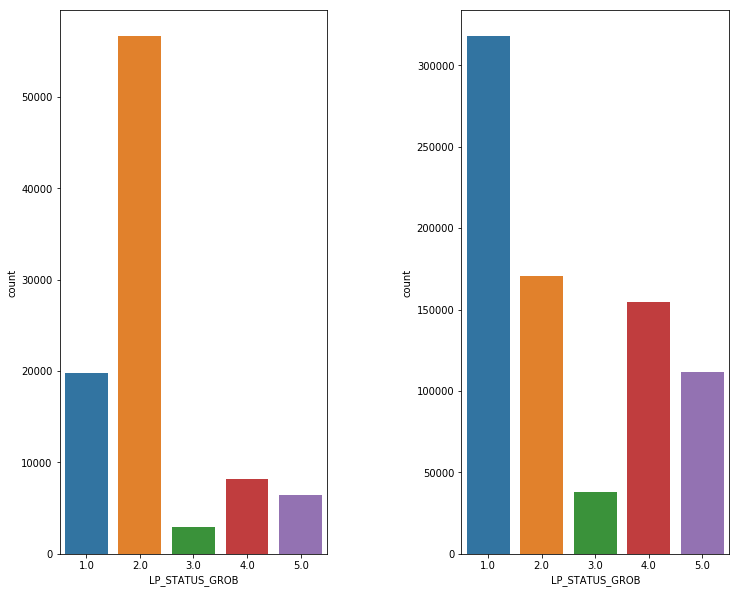

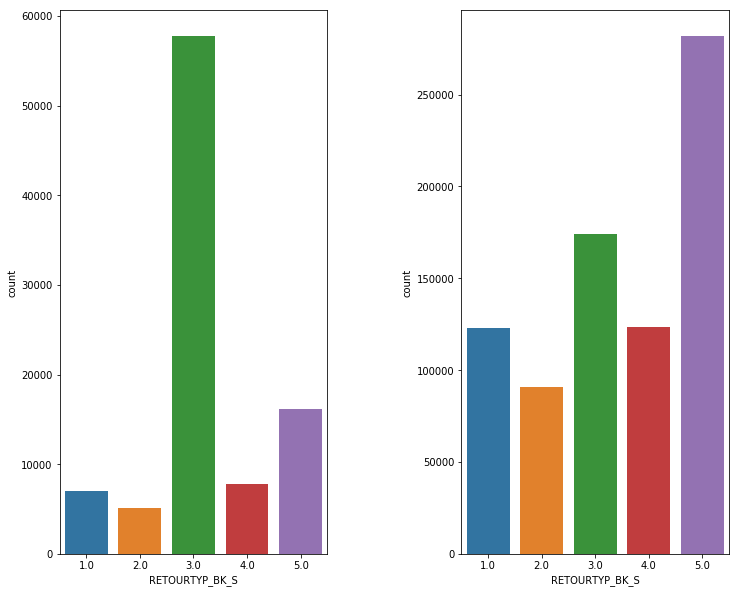

In [25]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def do_countplot(set1, set2, col):
    fig, ax =plt.subplots(1,2, figsize=(12, 10))
    sns.countplot(set1[col], ax=ax[0])
    sns.countplot(set2[col], ax=ax[1])
    plt.subplots_adjust(wspace= 0.5)
    fig.show()
#columns with small amount of missing data
cols = ['CJT_GESAMTTYP', 'ONLINE_AFFINITAET','LP_STATUS_FEIN','LP_STATUS_GROB','RETOURTYP_BK_S']
for col in cols:
    do_countplot(azdias_more_than_25, azdias_less_than_or_equal_25, col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

From histograms showing how much missing data in each row, I've decided to divide my data into two sets one containing the valuse less than or rqual 25% into a set and the other set contains the one with more than 25%.

from this point I will be using azdias_less_than_or_equal_25, and fill the null values.

we can also note after these distributions, both subset nearly have the same distribution, so I can say that deleting the missing data will not affect the distrubution and the data will keep the distributions balanced in the features, it's like most of the features are similar in both cases, for sure with some exceptions, but I prefer using the data with few missing values, even though the distribution will somehow remain the same.  

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [26]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
features = list(azdias_less_than_or_equal_25.columns)
feat_info_clean = feat_info[feat_info['attribute'].isin(features)]
catigorial_features = feat_info_clean[feat_info_clean["type"]=="categorical"]["attribute"]
binary_feature = []
multi_level_feature=[]
for feature in catigorial_features:
    if (len(azdias_less_than_or_equal_25[feature].unique())==2):
        binary_feature.append(feature)
    elif (len(azdias_less_than_or_equal_25[feature].unique())>2):
        multi_level_feature.append(feature)
print('Binary features are: {}'.format(binary_feature))
print('Multi-level features are: {}'.format(multi_level_feature))

Binary features are: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
Multi-level features are: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [28]:
for feature in binary_feature:
    print('Unique values for {} are {}'.format(feature, azdias_less_than_or_equal_25[feature].unique()))

Unique values for ANREDE_KZ are [2 1]
Unique values for GREEN_AVANTGARDE are [0 1]
Unique values for SOHO_KZ are [ 1.  0.]
Unique values for OST_WEST_KZ are ['W' 'O']


In [29]:
azdias_less_than_or_equal_25 = azdias_less_than_or_equal_25.replace({'OST_WEST_KZ':{'W': 0.0, 'O': 1.0}})
azdias_less_than_or_equal_25['OST_WEST_KZ'].unique()

array([ 0.,  1.])

In [30]:
#dropping the multi level features, so we will reduce the number of features we have, and fast the upcoming procedures
for i in multi_level_feature:
    if i in azdias_less_than_or_equal_25.columns:
        azdias_less_than_or_equal_25=azdias_less_than_or_equal_25.drop(i, axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

SO, what I've done so far is:

1) kept all the binary categorical features but re-ecoded the feature 'OST_WEST_KZ' and changed 'w' to 0 and 'o' to 1 

2) The remaining three two levels have been left without modifications, and all of the multi level features have been dropped. 


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [31]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#making the dictionary
decade_dictionary = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dictionary = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
azdias_less_than_or_equal_25['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_less_than_or_equal_25['PRAEGENDE_JUGENDJAHRE']
azdias_less_than_or_equal_25['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_less_than_or_equal_25['PRAEGENDE_JUGENDJAHRE']
azdias_less_than_or_equal_25['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(decade_dictionary, inplace=True)
azdias_less_than_or_equal_25['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(movement_dictionary, inplace=True)

In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
wealth_dictionary = {'11': 1, '12': 1, '13': 1, '14': 1, '15': 1, '21': 2, '22': 2, '23': 2, '24': 2, '25': 2, '31': 3, '32': 3, '33': 3, '34': 3, '35': 3, '41': 4, '42': 4, '43': 4, '44': 4, '45': 4, '51': 5, '52': 5, '53': 5, '54': 5, '55': 5}

life_stage_dictionary = {'11': 1, '12': 2, '13': 3, '14': 4, '15': 5, '21': 1, '22': 2, '23': 3, '24': 4, '25': 5, '31': 1, '32': 2, '33': 3, '34': 4, '35': 5, '41': 1, '42': 2, '43': 3, '44': 4, '45': 5, '51': 1, '52': 2, '53': 3, '54': 4, '55': 5}

azdias_less_than_or_equal_25['CAMEO_INTL_2015_WEALTH'] = azdias_less_than_or_equal_25['CAMEO_INTL_2015']
azdias_less_than_or_equal_25['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_less_than_or_equal_25['CAMEO_INTL_2015']

azdias_less_than_or_equal_25['CAMEO_INTL_2015_WEALTH'].replace(wealth_dictionary, inplace=True)
azdias_less_than_or_equal_25['CAMEO_INTL_2015_LIFE_STAGE'].replace(life_stage_dictionary, inplace=True)


In [33]:
#dropping the PRAEGENDE_JUGENDJAHRE & CAMEO_INTL_2015 because they have been splitted 
azdias_less_than_or_equal_25.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)
azdias_less_than_or_equal_25.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

For the PRAEGENDE_JUGENDJAHRE feature I've splitted it into movement and decade, for the CAMEO_INTL_2015 feature I've splitted it to wealth and life stage and then dropped them from azdias_less_than_or_equal_25 because we won't need them anymore 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [34]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [35]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
Mixed = feat_info_clean[feat_info_clean["type"]=="mixed"]["attribute"]
for i in Mixed:
    if i in azdias_less_than_or_equal_25:
        azdias_less_than_or_equal_25.drop(i, axis=1, inplace=True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [36]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Identify missing or unknown data values and convert them to NaNs.
    # Step 1            
    for i in range(len(feat_info)):
        Missing_Values = feat_info.iloc[i]['missing_or_unknown']
        Missing_Values = Missing_Values.strip('[')
        Missing_Values = Missing_Values.strip(']')
        Missing_Values = Missing_Values.split(sep=',')
        Missing_Values = [int(value) if (value!='X' and value!='XX' and value!='' and value!= '5C') else value for value in Missing_Values]
        if Missing_Values != ['']:
            df_clean = df.replace({feat_info.iloc[i]['attribute']: Missing_Values}, np.nan)
    for col in df.columns:
        df_clean = df_clean.replace({col: ['XX', 'X']}, np.nan)
    # Step2
    Missing_Col_Dropped = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df_clean = df_clean.drop(Missing_Col_Dropped, axis=1)
    null_rows_pct = df_clean.isnull().sum(axis=1)/len(df_clean.columns)*100
    df_clean = df_clean[null_rows_pct < 25]
    
    df_clean = df_clean.fillna(df_clean.mode().iloc[0])
    # Binary feature
    df_clean = df_clean.replace({'OST_WEST_KZ':{'W': 0, 'O': 1}})
    # Drop multi-level 
    features = list(azdias_less_than_or_equal_25.columns)
    feat_info_clean = feat_info[feat_info['attribute'].isin(features)]
    catigorial_features = feat_info_clean[feat_info_clean["type"]=="categorical"]["attribute"]
    binary_feature = []
    multi_level_feature=[]
    for feature in catigorial_features:
        if (len(azdias_less_than_or_equal_25[feature].unique())==2):
            binary_feature.append(feature)
        elif (len(azdias_less_than_or_equal_25[feature].unique())>2):
            multi_level_feature.append(feature)
    for i in multi_level_feature:
        if i in df_clean:
            df_clean=df_clean.drop(i, axis=1)
    # Mixed features
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    decade = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

    df_clean['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    df_clean['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE']

    df_clean['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(decade)
    df_clean['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(movement)

    wealth = {'11': 1, '12': 1, '13': 1, '14': 1, '15': 1, '21': 2, '22': 2, '23': 2, '24': 2, '25': 2, '31': 3, '32': 3, '33': 3, '34': 3, '35': 3, '41': 4, '42': 4, '43': 4, '44': 4, '45': 4, '51': 5, '52': 5, '53': 5, '54': 5, '55': 5}
    life_stage = {'11': 1, '12': 2, '13': 3, '14': 4, '15': 5, '21': 1, '22': 2, '23': 3, '24': 4, '25': 5, '31': 1, '32': 2, '33': 3, '34': 4, '35': 5, '41': 1, '42': 2, '43': 3, '44': 4, '45': 5, '51': 1, '52': 2, '53': 3, '54': 4, '55': 5}

    df_clean['CAMEO_INTL_2015_WEALTH'] = df_clean['CAMEO_INTL_2015']
    df_clean['CAMEO_INTL_2015_LIFE_STAGE'] = df_clean['CAMEO_INTL_2015']

    df_clean['CAMEO_INTL_2015_WEALTH'] = df_clean['CAMEO_INTL_2015_WEALTH'].replace(wealth)
    df_clean['CAMEO_INTL_2015_LIFE_STAGE'] = df_clean['CAMEO_INTL_2015_LIFE_STAGE'].replace(life_stage)

    df_clean = df_clean.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)
    Mixed = feat_info_clean[feat_info_clean["type"]=="mixed"]["attribute"]
    for i in Mixed:
        if i in df_clean:
            df_clean.drop(i, axis=1, inplace=True)
    
    return df_clean

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [37]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import  Imputer
normalization = Imputer(strategy='most_frequent')
azdias_new = pd.DataFrame(normalization.fit_transform(azdias_less_than_or_equal_25))
azdias_new.columns = azdias_less_than_or_equal_25.columns
azdias_new.index = azdias_less_than_or_equal_25.index

In [38]:
azdias_new.isnull().sum().sum()

0

In [39]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_ss = scaler.fit_transform(azdias_new)
azdias_new = pd.DataFrame(df_ss, columns=list(azdias_new))


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

So, basically I've replaced the null values in the variable containing less than 25% of missing values with most frequent value for each column, then used StandardScaler to transform the data into mean of 0 and std of 1, I've normalized the data using standardscaler.

In [40]:
azdias_new.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
0,-1.766173,0.958121,-1.494463,1.538139,-1.040664,1.466401,0.959974,1.338532,-0.530654,1.010291,...,0.441346,1.454540,0.57359,-0.171711,-0.127228,0.684698,1.098802,0.530654,1.175857,-1.249369
1,0.200733,0.958121,-1.494463,0.864753,-1.766903,-0.570914,0.245238,1.338532,1.884467,1.010291,...,-0.935871,0.418829,0.57359,-0.171711,-0.127228,-0.789243,1.098802,-1.884467,-0.869590,0.766691
2,1.184186,0.958121,0.683285,-0.482020,1.138052,-0.570914,-1.184235,-0.792444,-0.530654,-0.311793,...,-0.935871,-0.616882,0.57359,-1.173497,-0.997766,-0.052273,-0.267171,0.530654,-1.551406,-0.577349


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [41]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
azdias_pca = pca.fit(azdias_new)

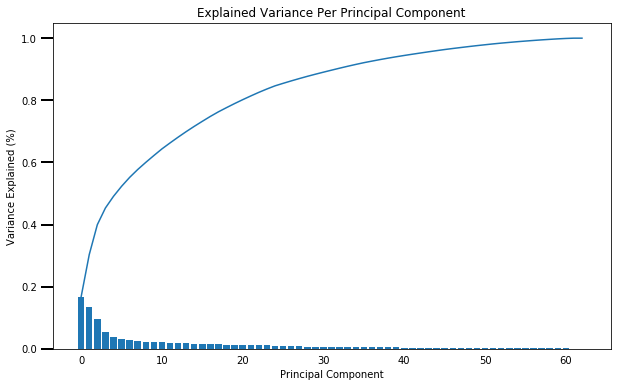

In [42]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)


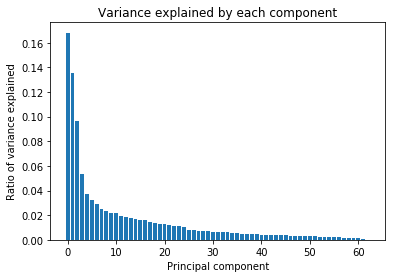

In [43]:
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

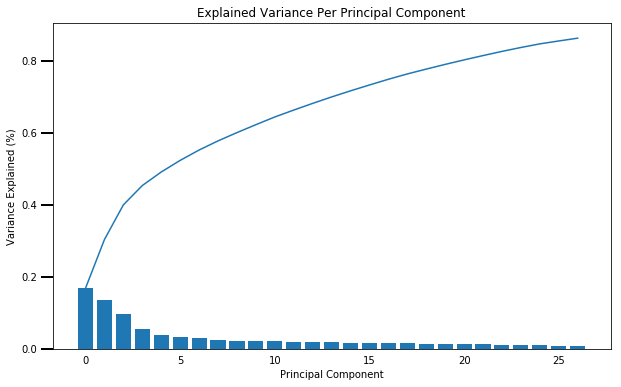

In [44]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=27)
azdias_pca = pca.fit(azdias_new)
scree_plot(pca)

In [45]:
sum(pca.explained_variance_ratio_)

0.8623388794495308

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

When applying PCA to the whole data (i.e. featues that has left after deleting the mixed and multi-level features0, that contained about 60 component, but when we reduced the number of components up to 27, it was able to explain about 86% of the whole data, which is something good, we have reduced the number of the components to less than 50% of the whole features, and it explained more than 86% of the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [46]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(azdias_new.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights
print (pca_weights(pca, 0))

PLZ8_ANTG3                        0.225110
PLZ8_ANTG4                        0.216725
CAMEO_INTL_2015_WEALTH            0.204567
HH_EINKOMMEN_SCORE                0.202166
ORTSGR_KLS9                       0.196381
EWDICHTE                          0.194201
FINANZ_HAUSBAUER                  0.159259
KBA05_ANTG4                       0.153784
FINANZ_SPARER                     0.153755
PLZ8_ANTG2                        0.153451
ARBEIT                            0.142393
KBA05_ANTG3                       0.136673
ANZ_HAUSHALTE_AKTIV               0.135861
RELAT_AB                          0.134715
SEMIO_PFLICHT                     0.121923
SEMIO_REL                         0.119452
PRAEGENDE_JUGENDJAHRE_DECADE      0.112931
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.110266
SEMIO_RAT                         0.100468
SEMIO_TRADV                       0.094758
SEMIO_MAT                         0.083777
FINANZ_UNAUFFAELLIGER             0.081778
SEMIO_FAM                         0.081628
SEMIO_KULT 

In [47]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print (pca_weights(pca, 1))

ALTERSKATEGORIE_GROB              0.256073
SEMIO_ERL                         0.229842
FINANZ_VORSORGER                  0.228710
SEMIO_LUST                        0.179857
RETOURTYP_BK_S                    0.161734
FINANZ_HAUSBAUER                  0.122568
SEMIO_KRIT                        0.117791
SEMIO_KAEM                        0.116830
W_KEIT_KIND_HH                    0.114908
PLZ8_ANTG3                        0.099484
EWDICHTE                          0.098531
ORTSGR_KLS9                       0.097317
PLZ8_ANTG4                        0.097208
ANREDE_KZ                         0.093644
CAMEO_INTL_2015_WEALTH            0.080147
KBA05_ANTG4                       0.075899
SEMIO_DOM                         0.074531
ARBEIT                            0.072455
RELAT_AB                          0.069825
PLZ8_ANTG2                        0.068824
ANZ_HAUSHALTE_AKTIV               0.067046
HH_EINKOMMEN_SCORE                0.062792
FINANZ_MINIMALIST                 0.058418
WOHNDAUER_2

In [48]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print (pca_weights(pca, 2))

SEMIO_VERT                        0.344684
SEMIO_SOZ                         0.261901
SEMIO_FAM                         0.248852
SEMIO_KULT                        0.233796
FINANZ_MINIMALIST                 0.154526
RETOURTYP_BK_S                    0.109189
FINANZ_VORSORGER                  0.101782
W_KEIT_KIND_HH                    0.085229
ALTERSKATEGORIE_GROB              0.079817
SEMIO_REL                         0.067836
SEMIO_LUST                        0.064632
SEMIO_MAT                         0.055645
ORTSGR_KLS9                       0.050276
EWDICHTE                          0.049486
PLZ8_ANTG4                        0.049139
PLZ8_ANTG3                        0.048495
GREEN_AVANTGARDE                  0.047103
ARBEIT                            0.037326
RELAT_AB                          0.034348
PLZ8_ANTG2                        0.032714
WOHNDAUER_2008                    0.032604
CAMEO_INTL_2015_WEALTH            0.030164
KBA05_ANTG4                       0.029976
ANZ_HAUSHAL

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

By taking a brief look at first principal component we can notice the following:

low-income earners, Social status, LP_STATUS_GROB
Estimated household net income, HH_EINKOMMEN_SCORE
Number of 6-10 family houses in the PLZ8 region, PLZ8_ANTG3
those are for the posotive values
in the other hand, 

region features, Movement patterns, MOBI_REGIO
Online affinity, ONLINE_AFFINITAET
Life stage, rough scale,  LP_LEBENSPHASE_GROB
Social status, fine scale, top earners,  LP_STATUS_FEIN
Social status, rough scale, top earners, LP_STATUS_GROB
those are have the negative weights, 

so first principal components can be divided as follows, wealth and income and family size
we can note also that, MOBI_REGIO and PLZ8_ANTG3 have a negative correlation. It means that when the share of 6-10 family homes in a macro-cell increases, it tends to have higher movements.


according to second principal components weights, we can not that:

Estimated age based on given name analysis, ALTERSKATEGORIE_GROB
Family type,  LP_FAMILIE_FEIN
Financial typology, for each dimensio, FINANZ_MINIMALIST
Customer-Journey-Typology: preferred information and buying channels for
consumer, Advertising- and Consumptiontraditionalist,  CJT_GESAMTTYP
those are with positive weights,

Dominating movement of person's youth, PRAEGENDE_JUGENDJAHRE
Family type, LP_FAMILIE_GROB
Personality typology, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST, SEMIO_ERL, SEMIO_KULT, SEMIO_RAT, SEMIO_KRIT
Financial typology, FINANZ_UNAUFFAELLIGER
those are with negative weights,

we can see also the inverse relationship between decade and age.

so pc2 can be divided according to personality typology and Financial typology and age 

finally, the third principal component, we can find:

Personality typology, VERT: dreamful,FAM: family-minded, SOZ: socially-minded, 
KULT: cultural-minded, SEMIO_VERT, SEMIO_SOZ, SEMIO_KULT
Type of building, GEBAEUDETYP
Social status, fine scale, Typical low-income earners, 3: aspiring low-income earners,
10: top earners,LP_STATUS_FEIN
those with positive weights

Social status, fine scale,2: orientation-seeking low-income earners,4: villagers, 
LP_STATUS_FEIN
Gender, ANREDE_KZ
Family type, LP_FAMILIE_GROB
Number of 1-2 family houses in the PLZ8 region, LZ8_ANTG1
those have negative weights

and it's noticable that high affinity for dreamful person, is in contrast to combative attitude person, and positively related to family and socially minded person

so we can conclude that PC3 tells us about the personality typologies and it's effect.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [49]:
from sklearn.cluster import KMeans
#defining a fucntion that returns the score
def kmeans_score(data, k_value):
    kmeans = KMeans(n_clusters = k_value)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [50]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
centers = list(range(2,20,2))
scores = []
azdias_pca = azdias_pca.transform(azdias_new)
for center in centers:  
    scores.append(kmeans_score(azdias_pca, center))  
    

Text(0.5,1,'SSE vs. K')

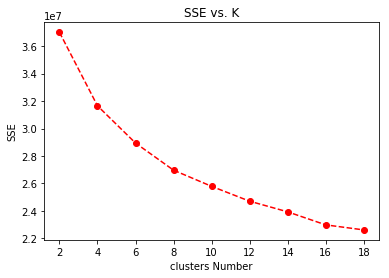

In [51]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='r');
plt.xlabel('clusters Number');
plt.ylabel('SSE');
plt.title('SSE vs. K')


In [52]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
model = KMeans(n_clusters=12)
azdias_predict = model.fit_predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Looking at SSE vs K graph, SSE decreases over K, and I see that after approximatly 12 clusters the rate became very low so I've decided to stick to 12 clusters 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [53]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', ';')

In [54]:
customers.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0


In [55]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_new=clean_data(customers)

In [56]:
#converting the strings in the data to NaN
customers_new = customers_new.applymap(lambda x: np.nan if isinstance(x, str) else x)

In [57]:
#deleting the extra features in customers data to make the size of customers_new equal the size of azdias_new for the
#transformations
features_not_in_azdias = []
for feature in customers_new.columns:
    if feature not in azdias_new.columns:
        features_not_in_azdias.append(feature)
features_not_in_azdias
customers_new = customers_new.drop(features_not_in_azdias, axis=1)

In [58]:
normalization = Imputer(strategy='most_frequent')
customers_new_imputed = pd.DataFrame(normalization.fit_transform(customers_new))
customers_new_imputed.columns = customers_new.columns
customers_new_imputed.index = customers_new.index

In [59]:
print(azdias_new.shape)
print(customers_new_imputed.shape)

(797077, 63)
(141690, 63)


In [60]:
customers_new_scaled = scaler.transform(customers_new_imputed)
customers_new_scaled = pd.DataFrame(customers_new_scaled, columns=list(customers_new_imputed))

In [61]:
customers_pca = pca.transform(customers_new_scaled)
customers_predict = model.predict(customers_pca)

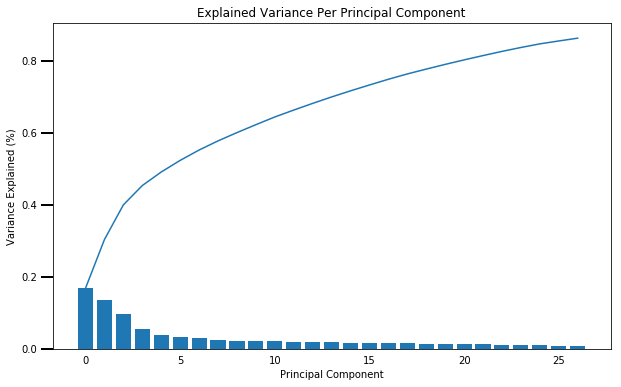

In [62]:
scree_plot(pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


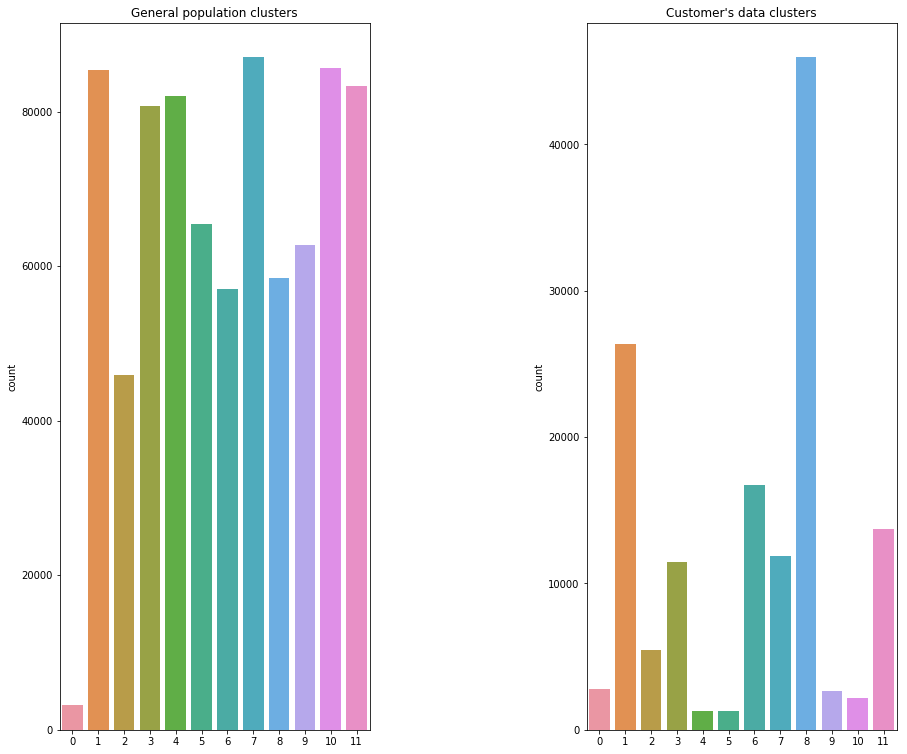

In [63]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, ax =plt.subplots(1,2, figsize=(15, 13))
sns.countplot(azdias_predict, ax=ax[0]).set_title('General population clusters')
sns.countplot(customers_predict, ax=ax[1]).set_title("Customer's data clusters")
plt.subplots_adjust(wspace= 0.7)
fig.show()


In [68]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_8 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[8]))
cluster_8 = pd.Series(data = cluster_8, index = customers_new.columns)


In [69]:
cluster_8.sort_values(ascending=False)


MIN_GEBAEUDEJAHR                  1993.034595
KBA13_ANZAHL_PKW                   698.670131
WOHNDAUER_2008                       8.438397
SEMIO_VERT                           6.221752
ORTSGR_KLS9                          5.335323
SEMIO_LUST                           5.223579
SEMIO_KULT                           4.896848
SEMIO_SOZ                            4.878818
SEMIO_FAM                            4.825242
FINANZ_MINIMALIST                    4.820175
INNENSTADT                           4.611932
W_KEIT_KIND_HH                       4.170351
FINANZ_VORSORGER                     4.158471
SEMIO_ERL                            4.105057
KBA05_GBZ                            4.071918
MOBI_REGIO                           4.062306
BALLRAUM                             4.033573
RETOURTYP_BK_S                       3.946559
GEBAEUDETYP_RASTER                   3.943370
EWDICHTE                             3.935724
SEMIO_MAT                            3.919105
PLZ8_GBZ                          

In [70]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_5 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[5]))
cluster_5 = pd.Series(data = cluster_5, index = customers_new.columns)

In [71]:
cluster_5.sort_values(ascending=False)

MIN_GEBAEUDEJAHR                  1992.636645
KBA13_ANZAHL_PKW                   526.627432
ANZ_HAUSHALTE_AKTIV                 14.702462
WOHNDAUER_2008                       7.157894
ORTSGR_KLS9                          6.961971
SEMIO_KULT                           6.825719
SEMIO_FAM                            6.718929
SEMIO_SOZ                            6.646733
SEMIO_REL                            6.273159
SEMIO_VERT                           6.016201
PRAEGENDE_JUGENDJAHRE_DECADE         5.710105
SEMIO_PFLICHT                        5.610388
HH_EINKOMMEN_SCORE                   5.474472
EWDICHTE                             5.144690
SEMIO_MAT                            5.051878
REGIOTYP                             4.956811
SEMIO_TRADV                          4.807545
W_KEIT_KIND_HH                       4.548725
CAMEO_INTL_2015_WEALTH               4.400626
FINANZ_SPARER                        4.340557
SEMIO_RAT                            4.078583
FINANZ_UNAUFFAELLIGER             

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

#### The segment of population that are more likely to be part of the mail-order company's main customer is in cluster 8:

##### type of people in this segment are as follow:
1) Type of building:

mixed building without actually known household or company
2) Customer-Journey-Typology:

preferred information and buying channels for

3) consumer:

Advertising- and Consumptionminimalist
Advertising- and Consumptiontraditionalist
advertisinginterested Online-shopper

4) Nationality based on given name analysis:

foreign-sounding
assimilated names

5) Most descriptive financial type for individual:

low financial interest (MINIMALIST)
investor (ANLEGER)

so they are more likely to be customers.

#### the segment of population that are less likely to be part of the mail-order company's main customer is in cluster 5:

##### type of people in this segment are as follow:
1) average earners:

houseowners
top earners

2) Most descriptive financial type for individual:

low financial interest (MINIMALIST)
home ownership (HAUSBAUER)
investor (ANLEGER)

3) Customer-Journey-Typology: 

preferred information and buying channels for consumer 

4) Advertising-Enthusiast with restricted Cross-Channel-Behaviour Shopper typology:

demanding shopper

Finally we can conclude that people with low incomes, are less likely to be customers and so company should focus on the clusters with high proportion in the customer data.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.